### 分析思路：
1、 提取日期特征，查看不同时间维度下互动数据波动的规律
 2、提取微博文本中的标签结构，例如话题标签，用户标签，表情标签，超链接，观察
 3、提取用户特征，观察用户属性对互动数据的影响规律

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import re

text_list=[]
with open('data/weibo_train_data.txt','r',encoding='utf-8') as f:
    for line in f.readlines():
        text_list.append(line.strip('\n').split('\t'))
train_dataframe=pd.DataFrame(text_list,columns=['用户id','博文id','时刻','转发数量','评论数量','点赞数量','博文内容'])    

text_list=[]
with open('data/weibo_predict_data.txt','r',encoding='utf-8') as f:
    for line in f.readlines():
        text_list.append(line.strip('\n').split('\t'))
test_dataframe=pd.DataFrame(text_list,columns=['用户id','博文id','时刻','博文内容'])     

# 将数据集拼接为总体数据集，统一进行特征工程处理，处理之后再分割为训练集和测试集
train_dataframe['转发数量'] = train_dataframe['转发数量'].astype(int)
train_dataframe['点赞数量'] = train_dataframe['点赞数量'].astype(int)
train_dataframe['评论数量'] = train_dataframe['评论数量'].astype(int)
#将训练集和测试集合并
total_dataframe = pd.concat([train_dataframe, test_dataframe], axis=0)

In [219]:
total_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1407915 entries, 0 to 178296
Data columns (total 7 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   用户id    1407915 non-null  object 
 1   博文id    1407915 non-null  object 
 2   时刻      1407915 non-null  object 
 3   转发数量    1229618 non-null  float64
 4   评论数量    1229618 non-null  float64
 5   点赞数量    1229618 non-null  float64
 6   博文内容    1407915 non-null  object 
dtypes: float64(3), object(4)
memory usage: 85.9+ MB


目前来看，数据集中没有空值和异常值。暂不进行处理。时刻为字符串格式，需要转换为datetime，strptime方法

### 抽取格式化特征
#### 抽取样本的日期特征

In [2]:
total_feature_df = pd.DataFrame()
feature_columns = []
#函数功能：添加特征以及特征类型
def insert_feature_tag(feature_name, feature_type):
    #feature_tag为元组，格式为(特征名，离散型i or 连续型f)
    feature_tag = (feature_name, feature_type)
    if feature_tag not in feature_columns:
        feature_columns.append(feature_tag)

import datetime
#将时刻转换为datetime格式
clock_seq = [datetime.datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in total_dataframe['时刻']]
#提取月份
clock_seq_month = [i.month for i in clock_seq]
#提取周
clock_seq_weekday = [i.weekday() for i in clock_seq]
#提取日
clock_seq_day = [i.day for i in clock_seq]
#提取小时
clock_seq_hour = [i.hour for i in clock_seq]
#提取分钟
clock_seq_minute = [i.minute for i in clock_seq]
#提取小时*60+分钟
clock_seq_minute_index = [i*60+j for i,j in zip(clock_seq_hour, clock_seq_minute)]
#添加月份列
total_feature_df['月计数'] = clock_seq_month
#添加月计数标签
insert_feature_tag('月计数', 'i')
#添加周列
total_feature_df['周计数'] = clock_seq_weekday
#添加周计数标签
insert_feature_tag('周计数', 'i')
#添加日列
total_feature_df['日计数'] = clock_seq_day
#添加日计数标签
insert_feature_tag('日计数', 'i')
#添加小时列
total_feature_df['时计数'] = clock_seq_hour
#添加时计数标签
insert_feature_tag('时计数', 'i')
#添加分钟列
total_feature_df['分计数'] = clock_seq_minute
#添加分计数标签
insert_feature_tag('分计数', 'i')
#添加小时+分钟列
total_feature_df['日内总分钟数'] = clock_seq_minute_index
#添加日内总分钟数标签，连续型特征
insert_feature_tag('日内总分钟数', 'f')

NameError: name 'pd' is not defined

In [1]:
total_feature_df.head()

NameError: name 'total_feature_df' is not defined

#### 抽取微博文本中的话题标签，用户标签，表情标签，超链接

In [338]:
def type_2_condition(content):
    pattern_1 = re.compile(r'向.*?@.*?提问')
    pattern_2 = re.compile(r'我在.*?提问')
    type_2_label = 0
    kernel_word_list = ['分享', '发表', '评论@', '评论给', '刚刚下载了豆丁文档', '通过@微盘 下载了',
                        '我刚刚下载了', '我刚下载了', '我刚才下载了', '我在#茶图素材网#下载了', '我正在关注',
                        '我上传了', '赞了 @', '我参与了']

    if pattern_1.findall(content) or pattern_2.findall(content):
        type_2_label = 1
    elif len(content) < 101:
        for kernel_word in kernel_word_list:
            if kernel_word in content[:20]:
                type_2_label = 1
    return type_2_label

# 话题的结构模式
pattern_topic = re.compile(r'#(.+?)#')
# 用户的结构模式
pattern_user = re.compile(r'@(.+?)[ ，@]')
# 表情的结构模式
pattern_face = re.compile(r'\[(.+?)\]')
# 超链接的结构模式
pattern_url = re.compile(r'http://t.cn/[a-zA-Z0-9]{7}')
# 超链接在最末尾的结构模式(在正则表达式中$代表文本的结束)
pattern_url_at_tail = re.compile(r'http://t.cn/[a-zA-Z0-9]{7}$')
# 标题的结构模式
pattern_title = re.compile(r'【.{6,}?】')

content_seq = total_dataframe['博文内容'].values
topic_tag_list = []
topic_tag_num_list = []
user_tag_list = []
user_tag_num_list = []
face_tag_list = []
face_tag_num_list = []
url_tag_list = []
url_at_tail_list = []
pic_tag_list = []
from_other_tag_list = []
uncomplete_tag_list = []
video_tag_list = []
auto_gene_tag_list = []
new_tag_list = []
is_computer_tag_list = []
is_stock_tag_list = []
is_promotion_tag_list = []
valid_content_len_list = []
valid_content_list = []
original_content_len_list = []
ppp_tag_list = []
for item_content in content_seq:
    # 话题标签
    topic_tag = pattern_topic.findall(item_content)
    topic_tag = [i for i in topic_tag if i.strip() != '']
    topic_tag_list.append(';'.join(topic_tag))
    topic_tag_num_list.append(len(topic_tag))
    # 用户标签
    user_tag = pattern_user.findall(item_content)
    user_tag = [i for i in user_tag if i.strip() != '']
    user_tag_list.append(';'.join(user_tag))
    user_tag_num_list.append(len(user_tag))
    # 表情标签
    face_tag = pattern_face.findall(item_content)
    face_tag = [i for i in face_tag if i.strip() != '']
    face_tag_list.append(';'.join(face_tag))
    face_tag_num_list.append(len(face_tag))
    # 文本中超链接的数量
    url_tag = pattern_url.findall(item_content)
    url_tag_list.append(len(url_tag))
    # 文本中超链接是否被放置在最末尾
    if pattern_url_at_tail.search(item_content):
        url_at_tail_list.append(1)
    else:
        url_at_tail_list.append(0)
    # 是否分享了图片
    if '分享图片' in item_content:
        pic_tag_list.append(1)
    else:
        pic_tag_list.append(0)
    # 该博文是否为转发
    item_mid_from_other = int('//' in item_content and 'http:' not in item_content)
    from_other_tag_list.append(item_mid_from_other)
    # 该博文是否未完全显示（没有完全显示的博文会在末尾区域有...，并辅导一个链接或者点击查看等文字）
    # 这样的博文本身是很长的，有一定的特殊性，所以需要记录下来。这里的30是假定未完全显示的博文...应该出现
    # 在倒数30个字符以内的位置。
    if '...' in item_content[-30:] and len(item_content) > 70:
        uncomplete_tag_list.append(1)
    else:
        uncomplete_tag_list.append(0)
    # 该博文是否插入视频，经过观察，微博中插入视频的样本通常都有“视频：”这样的格式
    if '视频：' in item_content:
        video_tag_list.append(1)
    else:
        video_tag_list.append(0)
    # 该博文是否为软件自动生成
    if type_2_condition(item_content):
        auto_gene_tag_list.append(1)
    else:
        auto_gene_tag_list.append(0)
    # 该博文中是否有标题，博文中标题通常有【xxx】这样的结构，有标题的博文通常是新闻报道类的
    if pattern_title.search(item_content):
        new_tag_list.append(1)
    else:
        new_tag_list.append(0)
    # 该博文的原始长度
    original_content_len_list.append(len(item_content))
    # 该博文中是否包含。。。这种特殊字符串
    if '。。。' in item_content:
        ppp_tag_list.append(1)
    else:
        ppp_tag_list.append(0)
    # 计算去掉格式化信息之后的博文长度
    item_content_strip = re.sub(r'#.+?#', '', item_content)
    item_content_strip = re.sub(r'http://t.cn/[0-9a-zA-Z]{7}', '', item_content_strip)
    item_content_strip = re.sub(r'（.*?@.*?）$', '', item_content_strip.strip())
    item_content_strip = re.sub(r'@.+?[ ，]', '', item_content_strip)
    item_content_strip = re.sub(r'\[.+?\]', '', item_content_strip)
    item_content_strip = re.sub(r'\(.*?\)$', '', item_content_strip)
    item_content_strip = re.sub(r'（.*?）$', '', item_content_strip)
    item_content_strip = re.sub(r'@.*?$', '', item_content_strip)
    valid_content_len_list.append(len(item_content_strip))
    valid_content_list.append(item_content_strip)
    # 对训练集的观察发现，与计算机相关的博文往往互动行为较多，所以可以通过一些关键词来判断该博文是否与计算机相关
    item_content_is_computer = 0 
    for keyword in ['Python', 'python', 'Java', 'java', 'JAVA', '计算机', '程序', '漏洞', '病毒',
                    '智能', '甲骨文', '谷歌', '微软', 'TensorFlow', 'PyTorch', 'Web', 'web', '云技术', '物联网',
                    'IT', '后端', '前端', '客户端', '科普', '硬件', '软件', '云计算', '开源', 'Git',
                    '代码', '框架', '算法', '版本', '科学', '数据挖掘', '数据库', '源码', 'bug', '数据分析', '服务器',
                   '互联网', 'Linux', '跨平台', 'CSS', 'SQL', '树莓派', '集群', '线程', '跨平台']:
        if keyword in item_content_strip:
            item_content_is_computer = 1
            break
    is_computer_tag_list.append(item_content_is_computer)
    # 微博中有大量荐股或者投资广告，所以这也是一类重要的博文，需要单独识别出来，我们也设定了一组关键词
    item_content_is_stock = 0
    for keyword in ['股票', '炒股', '理财', '投资', '盈利', '本金', '上证', '深证', '交易', '牛股', '指数',
                    '纳斯达克', '开盘', '收盘', '收益率', '股市', '套牢', '股神', '财经',
                    '宏观', '微观', '经济', '财报', '上市', '公司', '坐庄', '暴跌', '下跌', '股民', '投资者',
                   '成交量', '量能']:
        if keyword in item_content_strip:
            item_content_is_stock = 1
            break
    is_stock_tag_list.append(item_content_is_stock)
    # 微博中商业推广内容，所以这也是一类重要的博文，需要单独识别出来，我们也设定了一组关键词
    item_content_is_promotion = 0
    for keyword in ['红包', '转发', '推广', '点赞', '评论', '免费', '现金', '收藏', '广告', '签到', '福利', 'QQ群',
                    '专享', '小财神', '手气', '礼包', '券', '好运', '速来', '抽奖', '下载',
                     '查收', '领取', '打车', 'QQ：', 'wexin：', 'weixin：',
                   'QQ:', 'weixin:']:
        if keyword in item_content_strip:
            item_content_is_promotion = 1
            break
    is_promotion_tag_list.append(item_content_is_promotion)

column_name = '话题标签列表'
column_type = 'i'
total_feature_df[column_name] = topic_tag_list
insert_feature_tag(column_name, column_type)
column_name = '话题标签数量'
column_type = 'f'
total_feature_df[column_name] = topic_tag_num_list
insert_feature_tag(column_name, column_type)
column_name = '用户标签列表'
column_type = 'i'
total_feature_df[column_name] = user_tag_list
insert_feature_tag(column_name, column_type)
column_name = '用户标签数量'
column_type = 'f'
total_feature_df[column_name] = user_tag_num_list
insert_feature_tag(column_name, column_type)
column_name = '表情标签列表'
column_type = 'i'
total_feature_df[column_name] = face_tag_list
insert_feature_tag(column_name, column_type)
column_name = '表情标签数量'
column_type = 'f'
total_feature_df[column_name] = face_tag_num_list
insert_feature_tag(column_name, column_type)
column_name = '超链接标签数量'
column_type = 'f'
total_feature_df[column_name] = url_tag_list
insert_feature_tag(column_name, column_type)
column_name = '尾部超链接标记'
column_type = 'i'
total_feature_df[column_name] = url_at_tail_list
insert_feature_tag(column_name, column_type)
column_name = '图片标记'
column_type = 'i'
total_feature_df[column_name] = pic_tag_list
insert_feature_tag(column_name, column_type)
column_name = '转发标记'
column_type = 'i'
total_feature_df[column_name] = from_other_tag_list
insert_feature_tag(column_name, column_type)
column_name = '未完全显示标记'
column_type = 'i'
total_feature_df[column_name] = uncomplete_tag_list
insert_feature_tag(column_name, column_type)
column_name = '视频标记'
column_type = 'i'
total_feature_df[column_name] = video_tag_list
insert_feature_tag(column_name, column_type)
column_name = '自动生成标记'
column_type = 'i'
total_feature_df[column_name] = auto_gene_tag_list
insert_feature_tag(column_name, column_type)
column_name = '新闻标记'
column_type = 'i'
total_feature_df[column_name] = new_tag_list
insert_feature_tag(column_name, column_type)
column_name = '计算机标记'
column_type = 'i'
total_feature_df[column_name] = is_computer_tag_list
insert_feature_tag(column_name, column_type)
column_name = '股票标记'
column_type = 'i'
total_feature_df[column_name] = is_stock_tag_list
insert_feature_tag(column_name, column_type)
column_name = '推广标记'
column_type = 'i'
total_feature_df[column_name] = is_promotion_tag_list
insert_feature_tag(column_name, column_type)
column_name = '实际博文长度'
column_type = 'f'
total_feature_df[column_name] = valid_content_len_list
insert_feature_tag(column_name, column_type)
column_name = '截断博文内容'
column_type = 'i'
total_feature_df[column_name] = valid_content_list
insert_feature_tag(column_name, column_type)
column_name = '原始博文长度'
column_type = 'f'
total_feature_df[column_name] = original_content_len_list
insert_feature_tag(column_name, column_type)
column_name = '。。。标记'
column_type = 'i'
total_feature_df[column_name] = ppp_tag_list
insert_feature_tag(column_name, column_type)

In [27]:
total_feature_df_.columns

Index(['月计数', '周计数', '日计数', '时计数', '分计数', '日内总分钟数', '话题标签列表', '话题标签数量',
       '用户标签列表', '用户标签数量', '表情标签列表', '表情标签数量', '超链接标签数量', '尾部超链接标记', '图片标记',
       '转发标记', '未完全显示标记', '视频标记', '自动生成标记', '新闻标记', '计算机标记', '股票标记', '推广标记',
       '实际博文长度', '截断博文内容', '原始博文长度', '。。。标记', '有效博文占比', '用户id', '转发数量', '评论数量',
       '点赞数量', '实际博文长度分桶', '原始博文长度分桶', '有效博文占比分桶'],
      dtype='object')

In [339]:
# 增加一个实际博文长度与原始博文长度之间的比值指标
total_feature_df['有效博文占比'] = total_feature_df['实际博文长度'] / total_feature_df['原始博文长度']
insert_feature_tag('有效博文占比', 'f')
# 把用户ID列和三个社交指标附加在特征数据集上
total_feature_df['用户id'] = total_dataframe['用户id'].values
total_feature_df['转发数量'] = total_dataframe['转发数量'].values
total_feature_df['评论数量'] = total_dataframe['评论数量'].values
total_feature_df['点赞数量'] = total_dataframe['点赞数量'].values
# 因为测试集部分的社交指标为空值，所以丢弃掉
total_feature_df_ = total_feature_df.dropna()
# 将三个社交指标的类型转换为整型
total_feature_df_['转发数量'] = total_feature_df_['转发数量'].astype(int)
total_feature_df_['评论数量'] = total_feature_df_['评论数量'].astype(int)
total_feature_df_['点赞数量'] = total_feature_df_['点赞数量'].astype(int)
total_feature_df_['实际博文长度分桶'] = pd.qcut(total_feature_df_['实际博文长度'], q=10, 
                                        labels=['博文长度排序分组_%d' % i for i in range(10)])
total_feature_df_['原始博文长度分桶'] = pd.qcut(total_feature_df_['原始博文长度'], q=10, 
                                        labels=['原始博文长度排序分组_%d' % i for i in range(10)])
total_feature_df_['有效博文占比分桶'] = pd.cut(total_feature_df_['有效博文占比'], bins=np.linspace(0, 1, 10), 
                                        labels=['有效博文占比排序分组_%d' % i for i in range(9)]
                                      )

D:\anaconda\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
D:\anaconda\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
D:\anaconda\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

In [340]:
# 打印出每一种特征不同取值对应的目标量平均值和相应的样本量
# 平均值的差异反映了该特征对于目标量的变化有多大的影响，而样本量的多与少则可以反映平均值统计量的可靠程度
# 基于越多样本计算出来的平均值约可靠。

for cate_feature_name in ['周计数', '时计数', '分计数', '话题标签数量', '用户标签数量', '表情标签数量', '超链接标签数量',
                         '尾部超链接标记', '图片标记', '转发标记', '未完全显示标记', '视频标记', '自动生成标记', '新闻标记',
                         '计算机标记', '股票标记', '推广标记', '实际博文长度分桶', '原始博文长度分桶', '。。。标记', '有效博文占比分桶']:
    #cate_feature_name = '尾部超链接标记'
    target_feature_name = ['转发数量', "评论数量", '点赞数量']
    print(pd.concat([total_feature_df_.groupby(cate_feature_name)[target_feature_name].mean(),
               total_feature_df_.groupby(cate_feature_name)['用户id'].count()],
              axis=1))

         转发数量      评论数量      点赞数量    用户id
周计数                                      
0    3.496040  1.189901  2.031954  180447
1    3.755973  1.291836  2.082722  186807
2    3.273270  1.203897  2.020607  199934
3    3.733299  1.297440  2.148647  192005
4    3.299649  1.276671  2.184628  180124
5    3.524528  1.278953  2.696688  144551
6    3.714662  1.267273  2.531842  145750
         转发数量      评论数量      点赞数量   用户id
时计数                                     
0    1.613041  1.223602  2.158050  48801
1    1.353306  0.955282  1.694427  23883
2    1.258799  0.858715  1.885801  14177
3    1.512349  0.768129  1.595436  10122
4    1.129332  0.570102  0.853114   8830
5    3.718750  0.811062  1.380847  10432
6    2.907210  0.794642  1.157576  19819
7    2.246653  0.711745  1.187576  35479
8    3.216602  0.890096  1.637298  60835
9    4.837037  1.187478  2.306828  77545
10   3.253302  1.108870  1.589376  77974
11   4.756730  1.452645  2.323658  73108
12   4.390888  1.300584  2.494867  63320
13   3.

               转发数量       评论数量        点赞数量    用户id
超链接标签数量                                           
0          4.573256   2.234719    3.956596  474244
1          2.567478   0.606738    1.077793  719073
2          7.820601   1.223086    1.701812   33328
3         18.532461   2.315048    3.672370    1987
4         14.653451   1.763583    3.844347     681
5         47.041026   4.994872    8.528205     195
6         43.622222   6.644444   12.022222      45
7        118.095238  10.904762   39.785714      42
8        710.071429  65.642857  186.428571      14
9         82.250000  10.000000   13.000000       4
10        13.250000   1.000000    4.750000       4
11        64.000000  42.000000    2.000000       1
             转发数量      评论数量      点赞数量    用户id
尾部超链接标记                                      
0        4.570790  1.961938  3.457155  598784
1        2.555439  0.587498  1.037525  630834
          转发数量      评论数量      点赞数量     用户id
图片标记                                       
0     3.559819

In [393]:
def merge_sum_mean(col):
    sum_stats=concat_feature_df.groupby(col)[['转发数量','评论数量','点赞数量']].sum()
    mean_stats=concat_feature_df.groupby(col)[['转发数量','评论数量','点赞数量']].mean()
    merge_table=pd.merge(sum_stats,mean_stats,how='left',on=col)
    merge_table.to_csv('%s_table.csv' %col)
    return merge_table
#total_feature_df_.groupby('超链接标签数量')[['转发数量','评论数量','点赞数量']].sum().to_csv('url_sum.csv')
#total_feature_df_.groupby('超链接标签数量')[['转发数量','评论数量','点赞数量']].mean().to_csv('url_mean.csv')

In [383]:
uid_feature_df['用户-推广标记分桶']=pd.cut(uid_feature_df['用户-推广标记'],bins=np.linspace(0, 1, 11))
#uid_feature_df['用户-表情标签数量分桶'] = pd.qcut(uid_feature_df['用户-表情标签数量'], q=11, 
                                        #labels=['用户-表情标签数量分组_%d' % i for i in range(10)],duplicates='drop')


In [396]:
merge_sum_mean('分计数')

,转发数量_x,评论数量_x,点赞数量_x,转发数量_y,评论数量_y,点赞数量_y
分计数,,,,,,
0,331355.0,54959.0,166806.0,9.938960,1.648490,5.003329
1,61896.0,26204.0,43555.0,2.381623,1.008273,1.675901
2,71352.0,25510.0,44626.0,3.099431,1.108119,1.938491
3,103415.0,30362.0,60899.0,4.945956,1.452102,2.912574
4,201488.0,32693.0,106971.0,9.331604,1.514126,4.954196
5,269995.0,38108.0,154651.0,13.031276,1.839278,7.464212
6,123278.0,29177.0,73309.0,5.933673,1.404361,3.528543
7,89446.0,27365.0,66938.0,4.530976,1.386201,3.390811
8,86320.0,23890.0,58495.0,4.238645,1.173091,2.872330


In [395]:
concat_feature_df.groupby('分计数',as_index=False)[['转发数量','评论数量','点赞数量']].mean()

,分计数,转发数量,评论数量,点赞数量
0,0,9.938960,1.648490,5.003329
1,1,2.381623,1.008273,1.675901
2,2,3.099431,1.108119,1.938491
3,3,4.945956,1.452102,2.912574
4,4,9.331604,1.514126,4.954196
5,5,13.031276,1.839278,7.464212
6,6,5.933673,1.404361,3.528543
7,7,4.530976,1.386201,3.390811
8,8,4.238645,1.173091,2.872330
9,9,3.969535,1.302766,2.296387


In [368]:
merge_table=pd.merge(sum_stats,mean_stats,how='left',on=col)
merge_table.to_csv('%s_table.csv' %col)

Index(['用户id', '用户-总博文数量', '用户-最大转发数量', '用户-平均转发数量', '用户-标准差转发数量', '用户-最大评论数量',
       '用户-平均评论数量', '用户-标准差评论数量', '用户-最大点赞数量', '用户-平均点赞数量', '用户-标准差点赞数量',
       '用户-日内总分钟数', '用户-话题标签数量', '用户-用户标签数量', '用户-表情标签数量', '用户-超链接标签数量',
       '用户-尾部超链接标记', '用户-新闻标记', '用户-计算机标记', '用户-推广标记', '用户-实际博文长度',
       '用户-原始博文长度', '用户-有效博文占比', '用户-用户标签数量分桶', '用户-话题标签数量分桶', '用户-表情标签数量分桶',
       '用户-最大点赞数量分桶'],
      dtype='object')

观察各个特征不同取值与转发数量平均值及样本数量之间的关系，可以发现：

“周计数”这一指标对于转发数量是没有任何影响的，也就是说你在周几去发布这一博文对于转发数量没有影响。但“周计数”这一指标对点赞数量有一些影响，即周末的发布点赞数量会更多一些。

“时计数”上显然有明显的差异，所以它是有力的预测指标。

“分计数”是每一条博文发布时刻中的分钟数，从常识来看，应该对于社交行为是没有影响的，但是统计结果发现，这个指标居然有这么显著的影响。

“话题标签数量”指标上数值主要集中于0,1,2,3这四种情况，博文中有两个话题标签是最容易触发社交行为的，而有1个话题标签是最不利于触发社交行为的。

“用户标签数量”指标上，样本主要集中于0,1,2,3这四种情况上，显然只涉及到一个用户的博文是最不好的，而涉及到2个及以上的博文是比较受欢迎的。

“表情标签数量”这一指标上，样本主要集中于0,1,2,3,4这五种情况上，显然博文中包含1,2,3个表情的时候最受欢迎。

“超链接标签数量”这一指标上，样本主要集中于0,1,2三种情况，显然超链接数量为1的情况下社交互动比较少，而超链接数量为0或者2的情况下，社交互动会明显增多。

“尾部超链接标记”这一指标上，显然尾部没有超链接的情况转发数量会比较多。

在“图片标记”这一指标上，只要不太多的样本中包含图片，这部分样本得到的社交互动数量较少。

“转发标记”这一指标上，只有很少量的样本是属于转发类样本的，这一部分样本会得到更多的社交互动。

“未完全显示标记”这一指标上，约有5%的样本属于未完全显示的，这一部分样本显然没有得到更多的社交互动。

“视频标记”这一个指标上，约有1%的样本属于插入视频的，这一部分样本显然没有得到更多的社交互动。

“自动生成标记”这一指标上，约有7%的样本属于自动生成的，自动生成的样本会得到更多的转发，更少的评论和更多的点赞。这也是符合常识的。

“新闻标记”这一指标中，约有18%的样本属于新闻类，这一部分样本显然会得到更多的转发，而评论数量会有所下降，点赞数量波动较小。

“计算机标记”这一指标中，约有19%的样本属于计算机相关类博文，这一部分样本会得到更多的转发，而对其他指标没有啥影响。

“股票标记”这一指标中，约有6%的样本属于股票相关类博文，这一部分样本会得到更少的社交互动行为。

“推广标记”这一指标中，约有17%的样本属于推广相关类博文，这一部分样本会得到更多的转发，以及更少的点赞和评论。

“实际博文长度”这一指标中，实际博文字数越多，社交互动数量就相对更多。

“原始博文长度”这一指标中，只有原始博文长度特别长的时候，社交互动数量就会很多。

“。。。标记”这一指标中，出现。。。标记的博文占比为2%左右，出现这个标记的博文社交互动数量会有微量的增加，特别是在评论数量上，会有翻倍的效果。

### 识别关键话题，用户与表情
由于部分话题是某一时期内的热点，所以通常会获得更多的社交互动。我们在这里统计出不同话题对应的社交互动数量，以此来挑选出一部分具有预测能力的话题。

In [341]:
import seaborn as sns
tag_stats_map = {}
for i_tags, i_forward_n, i_comment_n, i_up_n in total_feature_df[['话题标签列表', '转发数量', '评论数量', '点赞数量']].values:
    i_total_social_n = i_forward_n + i_comment_n + i_up_n
    if np.isnan(i_total_social_n):
        continue
    for i_tag in i_tags.split(';'):
        if i_tag not in tag_stats_map:
            tag_stats_map[i_tag] = []
        tag_stats_map[i_tag].append(i_total_social_n)
tag_stats_map_aver = [[k, np.mean(v), len(v)] for k, v in tag_stats_map.items() if len(v) > 1000]
sorted_tag_stats = sorted(tag_stats_map_aver, key=lambda i: i[1])
sorted_tag_stats

[['IT', 0.025099627201439774, 31116],
 ['微博等级专享礼', 0.028516746411483253, 5225],
 ['快的打车，就摇快乐', 0.03517241379310345, 1450],
 ['快的打车代金券', 0.049788214312253845, 13457],
 ['科技', 0.05179110919292188, 2317],
 ['快的打车', 0.05956977385548814, 1813],
 ['天猫年中大促', 0.0967098703888335, 1003],
 ['微盘签到', 0.10111960191931757, 5627],
 ['扇贝打卡', 0.1232876712328767, 7154],
 ['春晚', 0.143281917859134, 5381],
 ['百词斩学霸认证', 0.17382906808305165, 2071],
 ['稀酷客(随书光盘)', 0.18873239436619718, 1420],
 ['百词斩', 0.18915343915343916, 2268],
 ['微盘', 0.37647521636506687, 5084],
 ['亚洲新歌榜', 0.4903786468032278, 3222],
 ['财经', 0.614307931570762, 1286],
 ['投资', 0.6979038224414303, 1622],
 ['理财', 0.6983343615052436, 1621],
 ['随手拍', 0.7700490998363339, 1222],
 ['NLP Job', 0.776536312849162, 2864],
 ['股神', 0.9318336741649625, 1467],
 ['炒股', 0.932140653917335, 1621],
 ['股市', 1.0149355057705363, 1473],
 ['股票', 1.08982748364069, 1681],
 ['克拉男神郑智薰', 3.2596248766041462, 3039],
 ['逗比总裁萧亮', 4.648809523809524, 3024],
 ['美拍', 6.3490364025695

既然要挑选一个具有预测性的话题标签，那么这个话题就应该具有一定程度的常见性，所以这里设定话题出现的次数不低于3000次。将满足这一要求的话题标签进行排序，就得到了上面的结果。显然“IT，微博等级专享礼，快的打车代金券，微盘签到，扇贝打卡，春晚，微盘，亚洲新歌榜”这几个标签属于低社交互动的标签，而“湾区日报，早安心语，rain克拉恋人，RAIN-JIHOON”属于高社交互动的标签。

同理，对用户标签和表情标签也做同样的处理，得到如下结果：

In [342]:
tag_stats_map = {}
for i_tags, i_forward_n, i_comment_n, i_up_n in total_feature_df[['用户标签列表', '转发数量', '评论数量', '点赞数量']].values:
    i_total_social_n = i_forward_n + i_comment_n + i_up_n
    if np.isnan(i_total_social_n):
        continue
    for i_tag in i_tags.split(';'):
        if i_tag not in tag_stats_map:
            tag_stats_map[i_tag] = []
        tag_stats_map[i_tag].append(i_total_social_n)
tag_stats_map_aver = [[k, np.mean(v), len(v)] for k, v in tag_stats_map.items() if len(v) > 1000]
sorted_tag_stats = sorted(tag_stats_map_aver, key=lambda i: i[1])
sorted_tag_stats

[['格瓦拉生活网', 0.0074487895716946, 1074],
 ['51CTO学院）', 0.03049645390070922, 1410],
 ['掌阅iReader', 0.03622540250447227, 2236],
 ['微彩票', 0.057126696832579184, 1768],
 ['快的打车', 0.05865177748181539, 19522],
 ['Weico微博客户端', 0.0616357171078625, 5062],
 ['fangshimin', 0.06589673913043478, 2944],
 ['让红包飞', 0.0864575363427697, 1307],
 ['支付宝钱包', 0.0893371757925072, 11798],
 ['郑州大学水利与环境学院团委', 0.1107172075265885, 3667],
 ['微盘', 0.2606568832983927, 7155],
 ['天猫', 0.29063604240282687, 1132],
 ['今日头条', 1.099639855942377, 1666],
 ['优酷）', 1.5516080777860883, 2674],
 ['优酷', 1.8903150525087515, 1714],
 ['知乎日报', 2.3685550604710377, 1571],
 ['电视剧-克拉恋人', 2.634534394010295, 2137],
 ['RAIN-JIHOON', 3.742216777169213, 13876],
 ['知乎', 3.9968012794882046, 5002],
 ['', 7.490123969033042, 988150],
 ['SegmentFault', 8.626101321585903, 1816]]

In [343]:
tag_stats_map = {}
for i_tags, i_forward_n, i_comment_n, i_up_n in total_feature_df[['表情标签列表', '转发数量', '评论数量', '点赞数量']].values:
    i_total_social_n = i_forward_n + i_comment_n + i_up_n
    if np.isnan(i_total_social_n):
        continue
    for i_tag in i_tags.split(';'):
        if i_tag not in tag_stats_map:
            tag_stats_map[i_tag] = []
        tag_stats_map[i_tag].append(i_total_social_n)
tag_stats_map_aver = [[k, np.mean(v), len(v)] for k, v in tag_stats_map.items() if len(v) > 1000]
sorted_tag_stats = sorted(tag_stats_map_aver, key=lambda i: i[1])
sorted_tag_stats

[['iso', 0.1608187134502924, 1710],
 ['转载', 0.16682926829268294, 2050],
 ['推荐', 1.2746121103940684, 7283],
 ['发红包', 2.6695254431103486, 10494],
 ['好棒', 2.8460176991150443, 1130],
 ['生病', 4.60377358490566, 2968],
 ['太开心', 5.078024941017863, 5934],
 ['晕', 5.24375, 1280],
 ['哼', 5.749118683901292, 1702],
 ['挖鼻屎', 6.038513210927004, 2233],
 ['太阳', 6.156791248860529, 1097],
 ['', 6.335240241406514, 1068571],
 ['怒', 6.391879562043796, 2192],
 ['泪流满面', 6.480600750938673, 1598],
 ['蜡烛', 6.534804753820034, 1767],
 ['噢耶', 7.321566110397946, 1558],
 ['馋嘴', 7.653876898481215, 1251],
 ['害羞', 7.907852564102564, 2496],
 ['呵呵', 8.090686274509803, 2040],
 ['微风', 8.502472799208704, 1011],
 ['喵喵', 9.044929396662388, 3116],
 ['可爱', 9.564336775218427, 2518],
 ['挖鼻', 10.079141515761235, 1491],
 ['礼物', 10.312896922325354, 8188],
 ['思考', 10.41676891615542, 2445],
 ['鼓掌', 10.622355541521944, 3167],
 ['阴险', 10.641481481481481, 1350],
 ['good', 12.330844155844156, 3080],
 ['衰', 12.771297278190174, 2829],
 ['话筒',

从统计结果来看，用户中低社交互动的有“快的打车，Weico微博客户端，支付宝钱包，郑州大学水利与环境学院团委，微盘”，高社交互动的没有。表情标签中低社交互动的有“推荐，发红包”，而高社交互动的有“喵喵，礼物，鼓掌，good，偷笑，泪，笑cry，嘻嘻，爱你，哈哈，心，doge，抓狂，拜拜”。基于这些结果，我们向特征集中增加相应的标签。

In [344]:
topic_low_value_list = 'IT，微博等级专享礼，快的打车代金券，微盘签到，扇贝打卡，春晚，微盘，亚洲新歌榜，快的打车，科技，天猫年中大促，百词斩学霸认证，稀酷客(随书光盘)，百词斩，财经，投资，理财，随手拍，NLP Job，股神，炒股，股市，股票'.split('，')
topic_high_value_list = '湾区日报，早安心语，rain克拉恋人，RAIN-JIHOON，武汉分享，技术分享，RAIN郑智薰出道13周年，Rain'.split('，')
user_low_value_list = '快的打车，Weico微博客户端，支付宝钱包，郑州大学水利与环境学院团委，微盘，格瓦拉生活网，51CTO学院），掌阅iReader，微彩票，fangshimin，让红包飞，天猫，今日头条，优酷，知乎日报，电视剧-克拉恋人'.split('，')
face_low_value_list = '推荐，发红包，iso，转载，好棒'.split('，')
face_high_value_list = '喵喵，礼物，鼓掌，good，偷笑，泪，笑cry，嘻嘻，爱你，哈哈，心，doge，抓狂，拜拜，挖鼻，思考，阴险，衰，话筒，得意地笑，酷，月亮，吃惊，偷乐，微笑，汗，围观，耶，怒骂，给力，色，花心，赞，威武，挤眼，悲伤，可怜'.split('，')

def gene_tag_value_list(column_name, tag_list):
    column_data = total_feature_df[column_name].values
    tag_value_list = []
    for i in column_data:
        label = 0
        for j in tag_list:
            if j in i:
                label = 1
                break
        tag_value_list.append(label)
    return tag_value_list

total_feature_df['低价值话题标签'] = gene_tag_value_list('话题标签列表', topic_low_value_list)
total_feature_df['高价值话题标签'] = gene_tag_value_list('话题标签列表', topic_high_value_list)
total_feature_df['低价值用户标签'] = gene_tag_value_list('用户标签列表', user_low_value_list)
total_feature_df['低价值表情标签'] = gene_tag_value_list('表情标签列表', face_low_value_list)
total_feature_df['高价值表情标签'] = gene_tag_value_list('表情标签列表', face_high_value_list)
column_name = '低价值话题标签'
column_type = 'i'
insert_feature_tag(column_name, column_type)
column_name = '高价值话题标签'
column_type = 'i'
insert_feature_tag(column_name, column_type)
column_name = '低价值用户标签'
column_type = 'i'
insert_feature_tag(column_name, column_type)
column_name = '低价值表情标签'
column_type = 'i'
insert_feature_tag(column_name, column_type)
column_name = '高价值表情标签'
column_type = 'i'
insert_feature_tag(column_name, column_type)

In [345]:
for cate_feature_name in ['低价值话题标签', '高价值话题标签', '低价值用户标签', '低价值表情标签', '高价值表情标签']:
    target_feature_name = ['转发数量', "评论数量", '点赞数量']
    print(pd.concat([total_feature_df.groupby(cate_feature_name)[target_feature_name].mean(),
               total_feature_df.groupby(cate_feature_name)['用户id'].count()],
              axis=1))

             转发数量      评论数量      点赞数量     用户id
低价值话题标签                                       
0        3.808067  1.356196  2.387750  1301529
1        0.388808  0.103174  0.220036   106386
             转发数量      评论数量      点赞数量     用户id
高价值话题标签                                       
0        3.484414  1.257699  2.150187  1381058
1        6.849181  1.200397  6.360923    26857
             转发数量      评论数量      点赞数量     用户id
低价值用户标签                                       
0        3.739876  1.328711  2.339001  1335415
1        0.157559  0.059967  0.165280    72500
             转发数量      评论数量      点赞数量     用户id
低价值表情标签                                       
0        3.589116  1.275794  2.247059  1385310
1        0.473995  0.144104  0.384373    22605
             转发数量     评论数量      点赞数量     用户id
高价值表情标签                                      
0        3.274677  1.09928  1.959785  1294742
1        6.541492  3.06214  5.149948   113173


另外，我们观察这些出现次数超过1000次的话题，用户，表情等，有几个要不出现次数特别多同时相应的社交互动明显偏离平均值，要不相应的社交互动数量远远偏离平均值。我们也把这一些特征作为模型特征之一。

In [346]:
total_feature_df['话题-IT'] = [1 if 'IT' in i else 0 for i in total_feature_df['话题标签列表']]
total_feature_df['话题-快的打车'] = [1 if '快的打车' in i else 0 for i in total_feature_df['话题标签列表']]
total_feature_df['话题-RAIN-JIHOON'] = [1 if 'RAIN-JIHOON' in i else 0 for i in total_feature_df['话题标签列表']]
total_feature_df['话题-Rain'] = [1 if 'Rain' in i else 0 for i in total_feature_df['话题标签列表']]
total_feature_df['话题-科技'] = [1 if '科技' in i else 0 for i in total_feature_df['话题标签列表']]
total_feature_df['话题-扇贝打卡'] = [1 if '扇贝打卡' in i else 0 for i in total_feature_df['话题标签列表']]
total_feature_df['话题-百词斩'] = [1 if '百词斩' in i else 0 for i in total_feature_df['话题标签列表']]
total_feature_df['话题-微盘签到'] = [1 if '微盘签到' in i else 0 for i in total_feature_df['话题标签列表']]
total_feature_df['用户-快的打车'] = [1 if '快的打车' in i else 0 for i in total_feature_df['用户标签列表']]
total_feature_df['用户-支付宝钱包'] = [1 if '支付宝钱包' in i else 0 for i in total_feature_df['用户标签列表']]
total_feature_df['用户-RAIN-JIHOON'] = [1 if 'RAIN-JIHOON' in i else 0 for i in total_feature_df['用户标签列表']]
total_feature_df['用户-掌阅iReader'] = [1 if '掌阅iReader' in i else 0 for i in total_feature_df['用户标签列表']]
total_feature_df['表情-发红包'] = [1 if '发红包' in i else 0 for i in total_feature_df['表情标签列表']]
total_feature_df['表情-泪'] = [1 if '泪' in i else 0 for i in total_feature_df['表情标签列表']]
total_feature_df['表情-笑cry'] = [1 if '笑cry' in i else 0 for i in total_feature_df['表情标签列表']]
total_feature_df['表情-哈哈'] = [1 if '哈哈' in i else 0 for i in total_feature_df['表情标签列表']]
total_feature_df['表情-心'] = [1 if '心' in i else 0 for i in total_feature_df['表情标签列表']]
total_feature_df['表情-doge'] = [1 if 'doge' in i else 0 for i in total_feature_df['表情标签列表']]
total_feature_df['表情-悲伤'] = [1 if '悲伤' in i else 0 for i in total_feature_df['表情标签列表']]
total_feature_df['表情-拜拜'] = [1 if '拜拜' in i else 0 for i in total_feature_df['表情标签列表']]
total_feature_df['表情-可怜'] = [1 if '可怜' in i else 0 for i in total_feature_df['表情标签列表']]
total_feature_df['表情-iso'] = [1 if 'iso' in i else 0 for i in total_feature_df['表情标签列表']]
total_feature_df['表情-转载'] = [1 if '转载' in i else 0 for i in total_feature_df['表情标签列表']]

single_tag_features = '话题-IT，话题-快的打车，话题-RAIN-JIHOON，话题-Rain，话题-科技，话题-扇贝打卡，话题-百词斩，话题-微盘签到，' + \
                        '用户-快的打车，用户-支付宝钱包，用户-RAIN-JIHOON，用户-掌阅iReader，表情-发红包，表情-泪，表情-笑cry，' + \
                        '表情-哈哈，表情-心，表情-doge，表情-悲伤，表情-拜拜，表情-可怜，表情-iso，表情-转载'
single_tag_features = single_tag_features.split('，')
for tag_feature in single_tag_features:
    insert_feature_tag(tag_feature, 'i')

### 用户属性特征
上面的工作完成了对每一条博文的文本特征抽取，而由于社交网络的存在，同样的博文由不同的用户发布所能够获得的互动行为是迥然不同的。所以需要统计出不同用户的特征以辅助对每一条博文进行预测。

In [237]:
user.columns

Index(['用户id', '用户-总博文数量', '用户-最大转发数量', '用户-平均转发数量', '用户-标准差转发数量', '用户-最大评论数量',
       '用户-平均评论数量', '用户-标准差评论数量', '用户-最大点赞数量', '用户-平均点赞数量', '用户-标准差点赞数量',
       '用户-日内总分钟数', '用户-话题标签数量', '用户-用户标签数量', '用户-表情标签数量', '用户-超链接标签数量',
       '用户-尾部超链接标记', '用户-新闻标记', '用户-计算机标记', '用户-推广标记', '用户-实际博文长度',
       '用户-原始博文长度', '用户-有效博文占比', '博文数量分桶', '用户时间分桶'],
      dtype='object')

In [238]:
uid_feature_df = total_feature_df.groupby('用户id')
uid_feature_map = {}
for uid, uid_df in uid_feature_df:
    user_tag=uid_df['话题标签数量'].mean()
    uid_feature_map[uid] = user_tag
    
    
    

In [250]:
df_tag=pd.DataFrame([uid_feature_map]).T.reset_index().rename(columns={'index':'用户id',0:'用户-话题标签数量'})


In [348]:
uid_feature_df = total_feature_df.groupby('用户id')
uid_feature_map = {}
for uid, uid_df in uid_feature_df:
    uid_feature = []
    # 该用户所发布博文的数量
    uid_content_num = len(uid_df)
    # 该用户所发布博文中的最大转发数量
    uid_forward_max = uid_df['转发数量'].max()
    if np.isnan(uid_forward_max):
        uid_forward_max = 0
    # 该用户所发布博文中的平均转发数量
    uid_forward_mean = uid_df['转发数量'].mean()
    if np.isnan(uid_forward_mean):
        uid_forward_mean = 0
    # 该用户所发布博文中的转发数量标准差
    uid_forward_std = uid_df['转发数量'].std()
    if np.isnan(uid_forward_std):
        uid_forward_std = 0
        
    # 该用户所发布博文中的最大评论数量
    uid_comment_max = uid_df['评论数量'].max()
    if np.isnan(uid_comment_max):
        uid_comment_max = 0
    # 该用户所发布博文中的平均评论数量
    uid_comment_mean = uid_df['评论数量'].mean()
    if np.isnan(uid_comment_mean):
        uid_comment_mean = 0
    # 该用户所发布博文中的评论数量标准差
    uid_comment_std = uid_df['评论数量'].std()
    if np.isnan(uid_comment_std):
        uid_comment_std = 0
        
    # 该用户所发布的博文中的最大点赞数量
    uid_up_max = uid_df['点赞数量'].max()
    if np.isnan(uid_up_max):
        uid_up_max = 0
    # 该用户所发布的博文中的平均点赞数量
    uid_up_mean = uid_df['点赞数量'].mean()
    if np.isnan(uid_up_mean):
        uid_up_mean = 0
    # 该用户所发布博文中的点赞数量标准差
    uid_up_std = uid_df['点赞数量'].std()
    if np.isnan(uid_up_std):
        uid_up_std = 0
            
    
    # 平均话题标签数量，表情标签数量，用户标签数量，超链接标签数量等指标
    temp_features = '日内总分钟数，话题标签数量，用户标签数量，表情标签数量，超链接标签数量，尾部超链接标记，新闻标记，' + \
                    '计算机标记，推广标记，实际博文长度，原始博文长度，有效博文占比'
    temp_features = temp_features.split('，')
    uid_other_avers = [uid_df[feature].mean() for feature in temp_features]
    #features_fmu=['转发数量','评论数量','点赞数量']
    #uid_static_mean=[uid_df[feature].mean() for feature in features_fmu]
    #uid_static_max=[uid_df[feature].max() for feature in features_fmu]
    #uid_static_std=[uid_df[feature].std() for feature in features_fmu]
    uid_feature_map[uid] = [uid_content_num, uid_forward_max, uid_forward_mean, uid_forward_std, uid_comment_max, uid_comment_mean, 
                            uid_comment_std, uid_up_max, uid_up_mean, uid_up_std] + uid_other_avers

In [350]:
temp_features = '总博文数量，最大转发数量，平均转发数量，标准差转发数量，最大评论数量，平均评论数量，标准差评论数量，' + \
            '最大点赞数量，平均点赞数量，标准差点赞数量，' + \
            '日内总分钟数，话题标签数量，用户标签数量，表情标签数量，超链接标签数量，尾部超链接标记，新闻标记，' + \
                    '计算机标记，推广标记，实际博文长度，原始博文长度，有效博文占比'
temp_features = ['用户-%s' % i for i in temp_features.split('，')]
#i为用户名，j为一系列统计值
uid_feature_array = [[i] + j for i,j in uid_feature_map.items()]
uid_feature_df = pd.DataFrame(uid_feature_array, columns=['用户id'] + temp_features)

In [351]:
uid_feature_df

,用户id,用户-总博文数量,用户-最大转发数量,用户-平均转发数量,用户-标准差转发数量,用户-最大评论数量,用户-平均评论数量,用户-标准差评论数量,用户-最大点赞数量,用户-平均点赞数量,...,用户-用户标签数量,用户-表情标签数量,用户-超链接标签数量,用户-尾部超链接标记,用户-新闻标记,用户-计算机标记,用户-推广标记,用户-实际博文长度,用户-原始博文长度,用户-有效博文占比
0,000127c6126e2b0019f255ed21ac1cb7,2,1.0,0.500000,0.707107,0.0,0.000000,0.000000,0.0,0.000000,...,0.500000,0.000000,1.000000,0.500000,0.000000,0.000000,0.000000,48.500000,71.500000,0.515785
1,0001565a5edece1669577e2ace9a6a3d,21,0.0,0.000000,0.000000,1.0,0.190476,0.402374,0.0,0.000000,...,0.523810,0.095238,0.904762,0.714286,0.380952,0.047619,0.666667,48.428571,78.000000,0.587604
2,00033a6513b86b2705de9ffa9d37ffb6,59,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.0,0.017241,...,0.288136,0.000000,0.966102,0.966102,0.000000,0.016949,0.983051,62.067797,90.288136,0.687001
3,0004fe2742507420eaa73e119dc83ac5,51,6.0,0.152174,0.893617,1.0,0.043478,0.206185,1.0,0.065217,...,0.431373,0.137255,1.000000,0.960784,0.156863,0.117647,0.176471,50.176471,75.980392,0.577143
4,000c663a24a2f91f4ba156fcd4f8b9f2,133,1.0,0.016393,0.127507,7.0,0.270492,0.927423,6.0,0.393443,...,0.075188,0.563910,0.263158,0.225564,0.045113,0.015038,0.030075,26.834586,35.436090,0.704489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37955,fffb96446162927dd6c69124f250bbf0,26,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.0,0.040000,...,0.500000,0.115385,0.923077,0.846154,0.076923,0.038462,0.692308,45.807692,71.461538,0.616044
37956,fffcc9de3131383d2c7111e2e15b740d,28,0.0,0.000000,0.000000,1.0,0.045455,0.213201,0.0,0.000000,...,0.107143,0.000000,0.428571,0.321429,0.142857,0.000000,0.035714,27.464286,39.607143,0.766982
37957,ffff3110aae05333d489d3707bee1d17,12,0.0,0.000000,0.000000,1.0,0.200000,0.421637,1.0,0.100000,...,0.166667,0.000000,0.750000,0.750000,0.083333,0.083333,0.083333,23.583333,40.333333,0.585286
37958,ffff39bf301adf32d06aae9dc70892fa,74,1.0,0.013699,0.117041,10.0,0.342466,1.356253,1.0,0.013699,...,0.391892,0.027027,0.824324,0.756757,0.000000,0.121622,0.567568,46.405405,70.364865,0.629773


In [352]:
concat_feature_df = pd.merge(left=total_feature_df, right=uid_feature_df, 
                             on='用户id', how='left')
concat_feature_df.iloc[10]

月计数                  2
周计数                  2
日计数                 11
时计数                 19
分计数                 29
               ...    
用户-计算机标记      0.355556
用户-推广标记      0.0444444
用户-实际博文长度      80.3444
用户-原始博文长度      106.811
用户-有效博文占比     0.782136
Name: 10, Length: 82, dtype: object

In [353]:
concat_feature_df.head()

,月计数,周计数,日计数,时计数,分计数,日内总分钟数,话题标签列表,话题标签数量,用户标签列表,用户标签数量,...,用户-用户标签数量,用户-表情标签数量,用户-超链接标签数量,用户-尾部超链接标记,用户-新闻标记,用户-计算机标记,用户-推广标记,用户-实际博文长度,用户-原始博文长度,用户-有效博文占比
0,2,0,23,17,41,1061,股票;炒股;财经;理财;投资,5,,0,...,0.011246,0.001298,0.268166,0.266869,0.016003,0.007353,0.639706,46.088668,74.880623,0.601692
1,2,5,14,12,49,769,丁辰灵的红包,1,阚洪岩,1,...,0.227027,0.118919,0.513514,0.383784,0.081081,0.210811,0.113514,39.718919,54.432432,0.723857
2,3,1,31,13,58,838,,0,,0,...,0.342857,0.000000,0.428571,0.400000,0.057143,0.028571,0.228571,41.257143,54.285714,0.823951
3,6,3,11,20,39,1239,,0,,0,...,0.272388,0.736940,0.270522,0.167910,0.013060,0.076493,0.042910,26.908582,38.945896,0.655579
4,3,1,10,18,2,1082,,0,,0,...,0.036364,0.036364,0.145455,0.127273,0.036364,0.127273,0.018182,20.836364,26.490909,0.696521


In [36]:
concat_columns = feature_columns + [(i, 'f') for i in temp_features] + [('用户id', 'i')]
# 被选为建模特征的列表
selected_features = '周计数，时计数，分计数，日内总分钟数，话题标签数量，用户标签数量，表情标签数量，超链接标签数量，尾部超链接标记，'+\
                    '图片标记，转发标记，未完全显示标记，视频标记，自动生成标记，新闻标记，计算机标记，股票标记，推广标记，实际博文长度'+\
                    '，原始博文长度，。。。标记，有效博文占比，低价值话题标签，高价值话题标签，低价值用户标签，低价值表情标签，高价值表情标签，'+\
                    '用户-总博文数量，用户-最大转发数量，用户-平均转发数量，用户-标准差转发数量，用户-最大评论数量，'+\
                    '用户-平均评论数量，用户-标准差评论数量，用户-最大点赞数量，用户-平均点赞数量，用户-标准差点赞数量，' + \
                    '用户-日内总分钟数，用户-话题标签数量，用户-用户标签数量'+\
                    '用户-表情标签数量，用户-超链接标签数量，用户-尾部超链接标记，用户-新闻标记，用户-计算机标记，用户-推广标记，' +\
                    '用户-实际博文长度，用户-原始博文长度，用户-有效博文占比，用户id' + \
                    '话题-IT，话题-快的打车，话题-RAIN-JIHOON，话题-Rain，话题-科技，话题-扇贝打卡，话题-百词斩，话题-微盘签到，' + \
                    '用户-快的打车，用户-支付宝钱包，用户-RAIN-JIHOON，用户-掌阅iReader，表情-发红包，表情-泪，表情-笑cry，' + \
                    '表情-哈哈，表情-心，表情-doge，表情-悲伤，表情-拜拜，表情-可怜，表情-iso，表情-转载'
selected_features = [i for i in concat_columns if i[0] in selected_features.split('，')]
# 把特征分为离散型特征和连续型特征
cate_features = [i[0] for i in selected_features if i[1] == 'i']
conti_features = [i[0] for i in selected_features if i[1] == 'f']

### 目标变量的基本特征

Text(0.5, 1.0, '点赞数量')

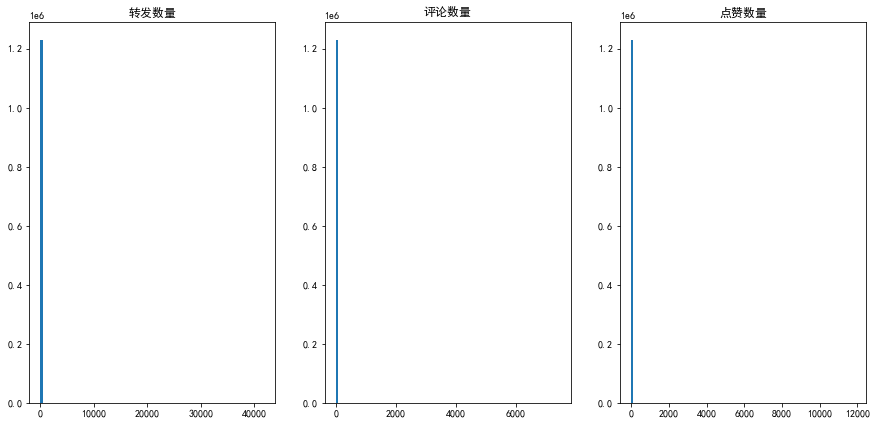

In [37]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #解决中文显示
plt.rcParams['axes.unicode_minus'] = False #解决符号无法显示

figure = plt.figure(figsize=(15, 7))
ax = figure.add_subplot(131)
_ = plt.hist(train_dataframe['转发数量'].values, bins=100)
plt.title('转发数量')
ax = figure.add_subplot(132)
_ = plt.hist(train_dataframe['评论数量'].values, bins=100)
plt.title('评论数量')
ax = figure.add_subplot(133)
_ = plt.hist(train_dataframe['点赞数量'].values, bins=100)
plt.title('点赞数量')

显然由于大量的博文没有任何的互动行为，所以，这些目标量集中于0。对于这种严重长尾分布的情况，我们应该进行一次对数变换，看看结果如何。

Text(0.5, 1.0, '点赞数量')

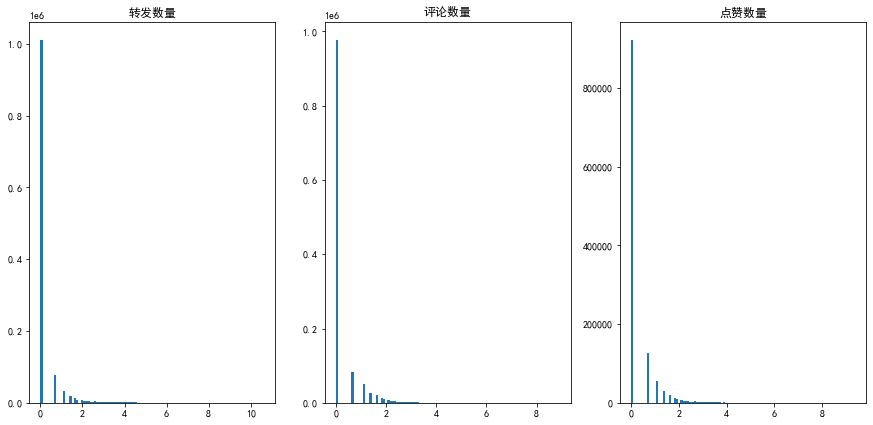

In [39]:
figure = plt.figure(figsize=(15, 7))
ax = figure.add_subplot(131)
_ = plt.hist(np.log(train_dataframe['转发数量'].values+1), bins=100)
plt.title('转发数量')
ax = figure.add_subplot(132)
_ = plt.hist(np.log(train_dataframe['评论数量'].values+1), bins=100)
plt.title('评论数量')
ax = figure.add_subplot(133)
_ = plt.hist(np.log(train_dataframe['点赞数量'].values+1), bins=100)
plt.title('点赞数量')


显然进行一次对数变换之后，数据分布情况依然呈现为对数正态分布，所以要再进行一次对数变换。

Text(0.5, 1.0, '点赞数量')

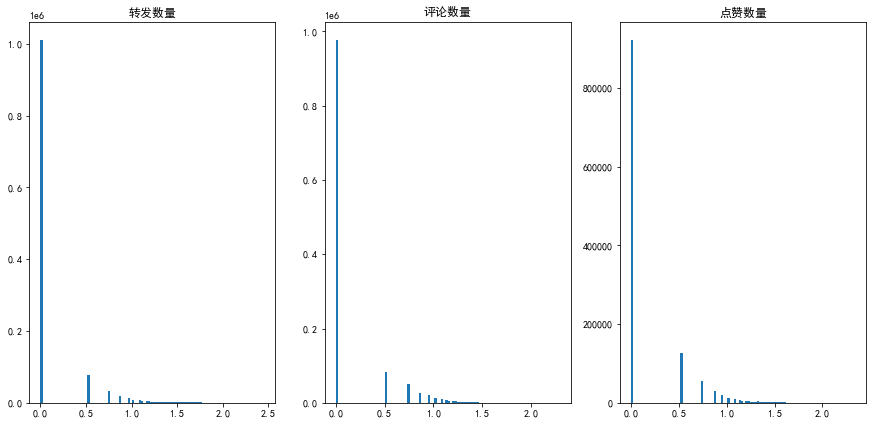

In [40]:
figure = plt.figure(figsize=(15, 7))
ax = figure.add_subplot(131)
_ = plt.hist(np.log(np.log(train_dataframe['转发数量'].values+1)+1), bins=100)
plt.title('转发数量')
ax = figure.add_subplot(132)
_ = plt.hist(np.log(np.log(train_dataframe['评论数量'].values+1)+1), bins=100)
plt.title('评论数量')
ax = figure.add_subplot(133)
_ = plt.hist(np.log(np.log(train_dataframe['点赞数量'].values+1)+1), bins=100)
plt.title('点赞数量')

显然再次经过对数变换之后，数据分布依然没有调整为对称的近似正态分布。不过暂时先这样处理，后续我们再讨论如何使用统计技术去改进模型。

In [41]:
y_train_forward = np.log(np.log(train_dataframe['转发数量'].values+1)+1)
y_train_comment = np.log(np.log(train_dataframe['评论数量'].values+1)+1)
y_train_up = np.log(np.log(train_dataframe['点赞数量'].values+1)+1)
#y_train_forward = np.log(train_dataframe['转发数量'].values+1)
#y_train_comment = np.log(train_dataframe['评论数量'].values+1)
#y_train_up = np.log(train_dataframe['点赞数量'].values+1)

In [42]:
x_train = concat_feature_df[cate_features + conti_features].iloc[:len(train_dataframe)]
x_test = concat_feature_df[cate_features + conti_features].iloc[len(train_dataframe):]

In [ ]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

def score_forward(real, pred):
    real = np.array(real)
    pred = np.array(pred)
    dev = np.abs(real - pred) / (real + 5)
    return dev, sum(dev * (real+1)) / sum(real+1)

def score_comment(real, pred):
    real = np.array(real)
    pred = np.array(pred)
    dev = np.abs(real - pred) / (real + 3)
    return dev, sum(dev * (real+1)) / sum(real+1)

def score_up(real, pred):
    real = np.array(real)
    pred = np.array(pred)
    dev = np.abs(real - pred) / (real + 3)
    return dev, sum(dev * (real+1)) / sum(real+1)

def score(real_array, pred_array):
    real_array = np.array(real_array)
    pred_array = np.array(pred_array)
    
    d_f, _ = score_forward(real_array[0], pred_array[0])
    d_c, _ = score_comment(real_array[1], pred_array[1])
    d_l, _ = score_up(real_array[2], pred_array[2])
    precision = 1 - 0.5*d_f - 0.25*d_c - 0.25*d_l
    count = np.sum(real_array, axis=0)+1
    count = np.array([min(i, 100) for i in count])
    sgn = np.array([1 if i-0.8>0 else 0 for i in precision])
    score = sum(count * sgn) / sum(count)
    return score

cb_params = {
        'n_estimators': 12000,
        'loss_function': 'RMSE',
        'eval_metric': 'MAE',
        'learning_rate': 0.02,
        'depth': 12,
        'use_best_model': True,
        'subsample': 0.7,
        'bootstrap_type': 'Bernoulli',
        'reg_lambda': 2,
        'task_type': "GPU",
        'devices': '0:1',
        'cat_features': cate_features
    }

y_test_forward_pred_list = []
y_test_comment_pred_list = []
y_test_up_pred_list = []
for i in range(5):
    print('第 %d 次随机抽样试验' % i)
    print('对转发数量进行预测')
    item_x_train, item_x_valid, item_y_train, item_y_valid = train_test_split(x_train, y_train_forward, 
                                                                              test_size=0.15, random_state=100*i)

    cat_model = CatBoostRegressor(**cb_params)
    cat_model.fit(item_x_train, item_y_train, eval_set=(item_x_valid, item_y_valid), verbose=1000, 
                  early_stopping_rounds=500, 
                  sample_weight=np.exp(item_y_train) # 由于在总体评分机制中高社交数量的样本权重更大，所以在拟合函数中，我们也提高相应的权重
                 )
    y_test_forward_pred = cat_model.predict(x_test)
    y_test_forward_pred_list.append(np.exp(np.exp(y_test_forward_pred)-1)-1)
    # 评分
    item_y_valid_pred = cat_model.predict(item_x_valid)
    item_y_valid_pred = np.exp(np.exp(item_y_valid_pred)-1)-1
    item_y_valid_temp = np.exp(np.exp(item_y_valid)-1)-1
    #item_y_valid_pred = np.exp(item_y_valid_pred)-1
    #item_y_valid_temp = np.exp(item_y_valid)-1
    count = 0
    for a, b in zip(item_y_valid_temp, item_y_valid_pred):
        print('实际值 --> 预测值：%d --> %d' % (round(a), round(b)))
        count += 1
        if count > 10:
            break
    count = 0
    for a, b in zip(item_y_valid_temp, item_y_valid_pred):
        if a < 10:
            continue
        print('实际值 --> 预测值：%d --> %d' % (round(a), round(b)))
        count += 1
        if count > 10:
            break
    _, s = score_forward(item_y_valid_temp, item_y_valid_pred)
    print('预测误差率为：%.3f' % s)
    y_valid_forward_pred = item_y_valid_pred
    y_valid_forward_real = item_y_valid_temp
    
    print('对评论数量进行预测')
    item_x_train, item_x_valid, item_y_train, item_y_valid = train_test_split(x_train, y_train_comment, 
                                                                              test_size=0.15, random_state=100*i)

    cat_model = CatBoostRegressor(**cb_params)
    cat_model.fit(item_x_train, item_y_train, eval_set=(item_x_valid, item_y_valid), verbose=1000, 
                  early_stopping_rounds=500, 
                  sample_weight=np.exp(item_y_train) # 由于在总体评分机制中高社交数量的样本权重更大，所以在拟合函数中，我们也提高相应的权重
                 )
    y_test_comment_pred = cat_model.predict(x_test)
    y_test_comment_pred_list.append(np.exp(np.exp(y_test_comment_pred)-1)-1)
    # 评分
    item_y_valid_pred = cat_model.predict(item_x_valid)
    item_y_valid_pred = np.exp(np.exp(item_y_valid_pred)-1)-1
    item_y_valid_temp = np.exp(np.exp(item_y_valid)-1)-1
    #item_y_valid_pred = np.exp(item_y_valid_pred)-1
    #item_y_valid_temp = np.exp(item_y_valid)-1
    count = 0
    for a, b in zip(item_y_valid_temp, item_y_valid_pred):
        print('实际值 --> 预测值：%d --> %d' % (round(a), round(b)))
        count += 1
        if count > 10:
            break
    count = 0
    for a, b in zip(item_y_valid_temp, item_y_valid_pred):
        if a < 10:
            continue
        print('实际值 --> 预测值：%d --> %d' % (round(a), round(b)))
        count += 1
        if count > 10:
            break
    _, s = score_comment(item_y_valid_temp, item_y_valid_pred)
    print('预测误差率为：%.3f' % s)
    y_valid_comment_pred = item_y_valid_pred
    y_valid_comment_real = item_y_valid_temp
    
    print('对点赞数量进行预测')
    item_x_train, item_x_valid, item_y_train, item_y_valid = train_test_split(x_train, y_train_up, 
                                                                              test_size=0.15, random_state=100*i)

    cat_model = CatBoostRegressor(**cb_params)
    cat_model.fit(item_x_train, item_y_train, eval_set=(item_x_valid, item_y_valid), verbose=1000, 
                  early_stopping_rounds=500, 
                  sample_weight=np.exp(item_y_train) # 由于在总体评分机制中高社交数量的样本权重更大，所以在拟合函数中，我们也提高相应的权重
                 )
    y_test_up_pred = cat_model.predict(x_test)
    y_test_up_pred_list.append(np.exp(np.exp(y_test_up_pred)-1)-1)
    # 评分
    item_y_valid_pred = cat_model.predict(item_x_valid)
    item_y_valid_pred = np.exp(np.exp(item_y_valid_pred)-1)-1
    item_y_valid_temp = np.exp(np.exp(item_y_valid)-1)-1
    #item_y_valid_pred = np.exp(item_y_valid_pred)-1
    #item_y_valid_temp = np.exp(item_y_valid)-1
    count = 0
    for a, b in zip(item_y_valid_temp, item_y_valid_pred):
        print('实际值 --> 预测值：%d --> %d' % (round(a), round(b)))
        count += 1
        if count > 10:
            break
    count = 0
    for a, b in zip(item_y_valid_temp, item_y_valid_pred):
        if a < 10:
            continue
        print('实际值 --> 预测值：%d --> %d' % (round(a), round(b)))
        count += 1
        if count > 10:
            break
    _, s = score_forward(item_y_valid_temp, item_y_valid_pred)
    print('预测误差率为：%.3f' % s)
    y_valid_up_pred = item_y_valid_pred
    y_valid_up_real = item_y_valid_temp
    
    valid_pred = [y_valid_forward_pred, y_valid_comment_pred, y_valid_up_pred]
    valid_real = [y_valid_forward_real, y_valid_comment_real, y_valid_up_real]
    i_score = score(valid_real, valid_pred)
    print('本次抽样的测试得分为：%.2f %%' % (i_score * 100))


In [ ]:
y_test_forward_pred = np.mean(y_test_forward_pred_list, axis=0)
y_test_comment_pred = np.mean(y_test_comment_pred_list, axis=0)
y_test_up_pred = np.mean(y_test_up_pred_list, axis=0)

y_test_pred_matrix = np.array([y_test_forward_pred, y_test_comment_pred, y_test_up_pred]).T

def write_outcome(y_test_pred_matrix, test_dataframe):
    with open('outcome.txt', 'w') as f:
        for line in np.hstack([test_dataframe[['用户id', '博文id']].values, y_test_pred_matrix]):
            s = f'{line[0]}\t{line[1]}\t{round(line[2]):d},{round(line[3]):d},{round(line[4]):d}\n'
            f.write(s)
write_outcome(y_test_pred_matrix, test_dataframe)